# Medical Cost Insurance Model

### Step-1- Import Libraries

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, precision_recall_curve,
    recall_score, f1_score, ConfusionMatrixDisplay, classification_report
)
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

### Step-2- Load DataSet

In [42]:
df = pd.read_csv('medical_insurance.csv')

columns= ['age','income','household_size','dependents',
          'bmi','visits_last_year','sex','region','urban_rural',
          'education','marital_status','employment_status','smoker','alcohol_freq'
]
target = 'annual_medical_cost'
categorical_cols = [
    'sex', 'region', 'urban_rural', 'marital_status', 
    'education', 'employment_status', 'smoker', 'alcohol_freq'
]
numerical_cols = [col for col in features if col not in categorical_cols]
X=df[features]
Y=df[target]
df.head()

,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,dependents,bmi,smoker,alcohol_freq,visits_last_year,annual_medical_cost
0,52,Female,North,Suburban,22700,Doctorate,Married,Retired,3,1,27.4,Never,NaN,2,6938.06
1,79,Female,North,Urban,12800,No HS,Married,Employed,3,1,26.6,Never,Weekly,2,1632.61
2,68,Male,North,Rural,40700,HS,Married,Retired,5,3,31.5,Never,NaN,1,7661.01
3,15,Male,North,Suburban,15600,Some College,Married,Self-employed,5,3,31.6,Never,NaN,0,5130.27
4,53,Male,Central,Suburban,89600,Doctorate,Married,Self-employed,2,0,30.5,Never,Daily,3,1700.73


### Step-3- Data Analysis

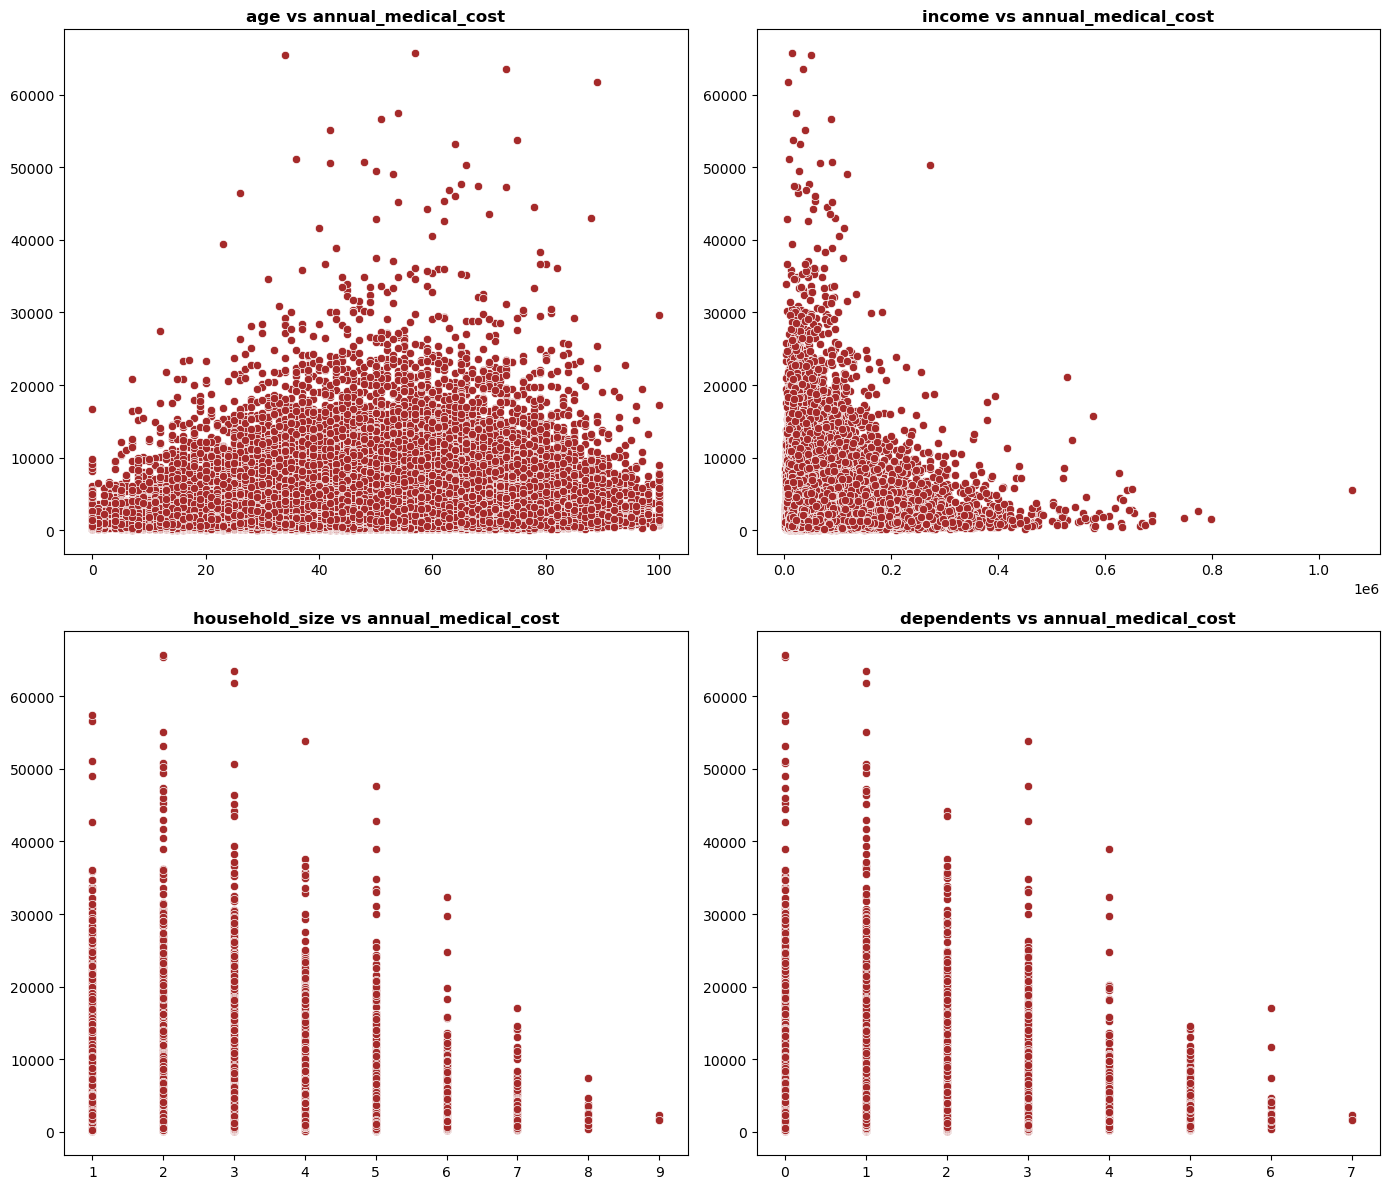

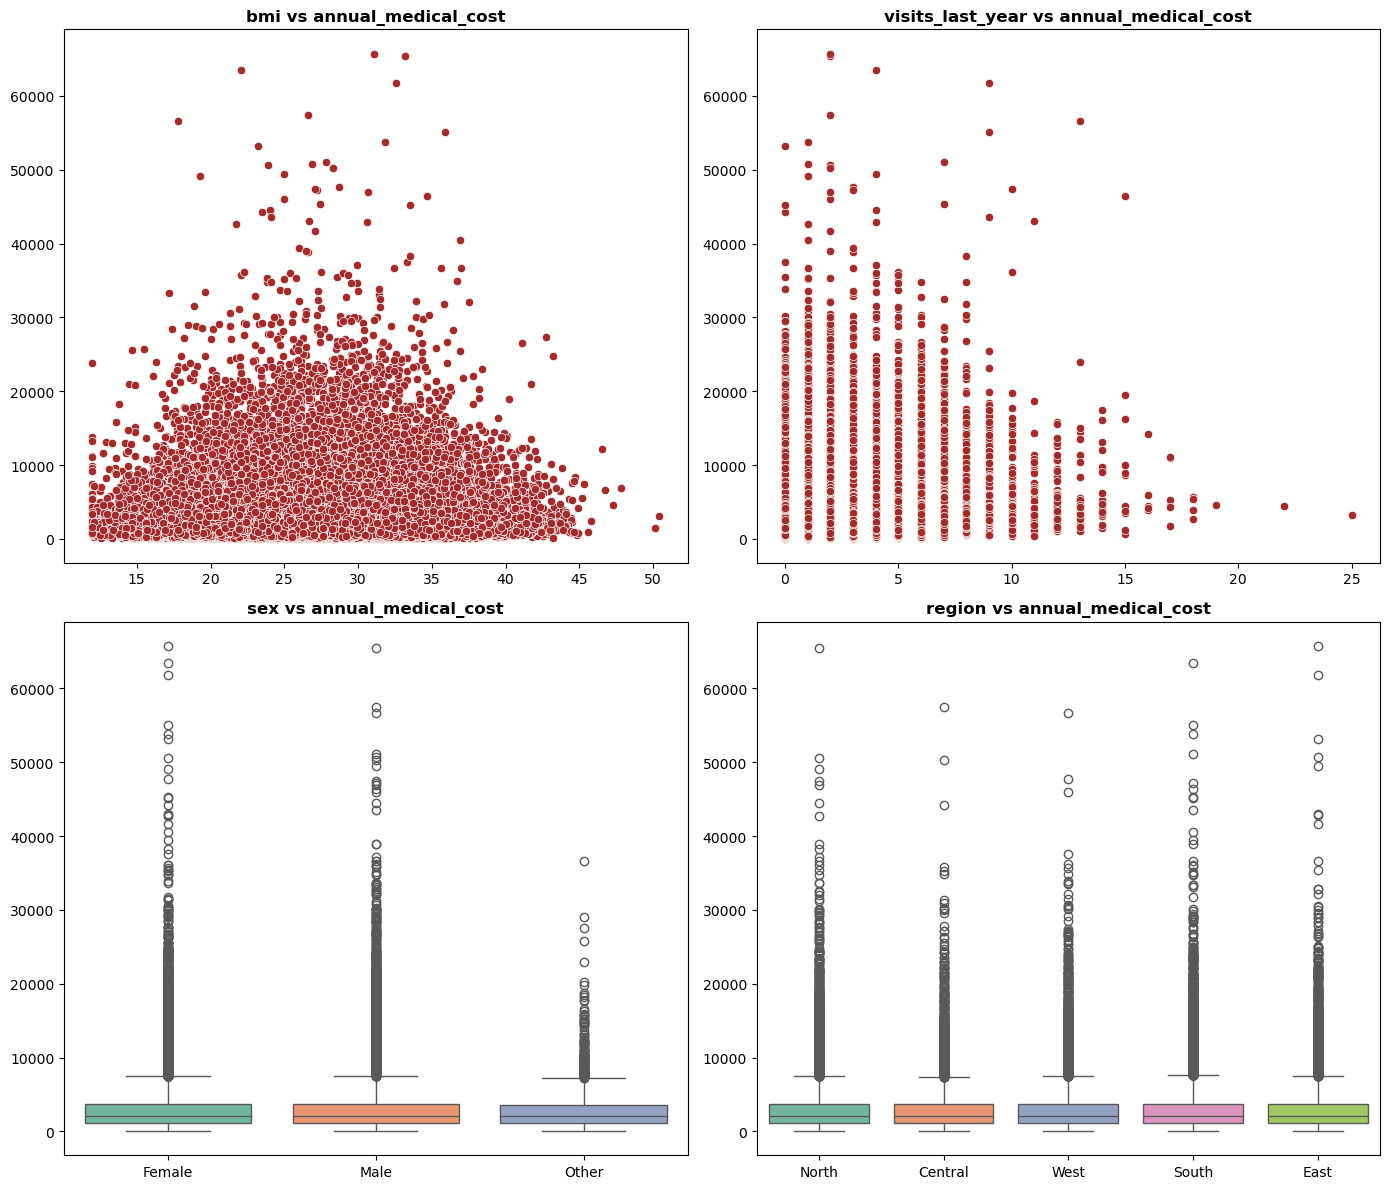

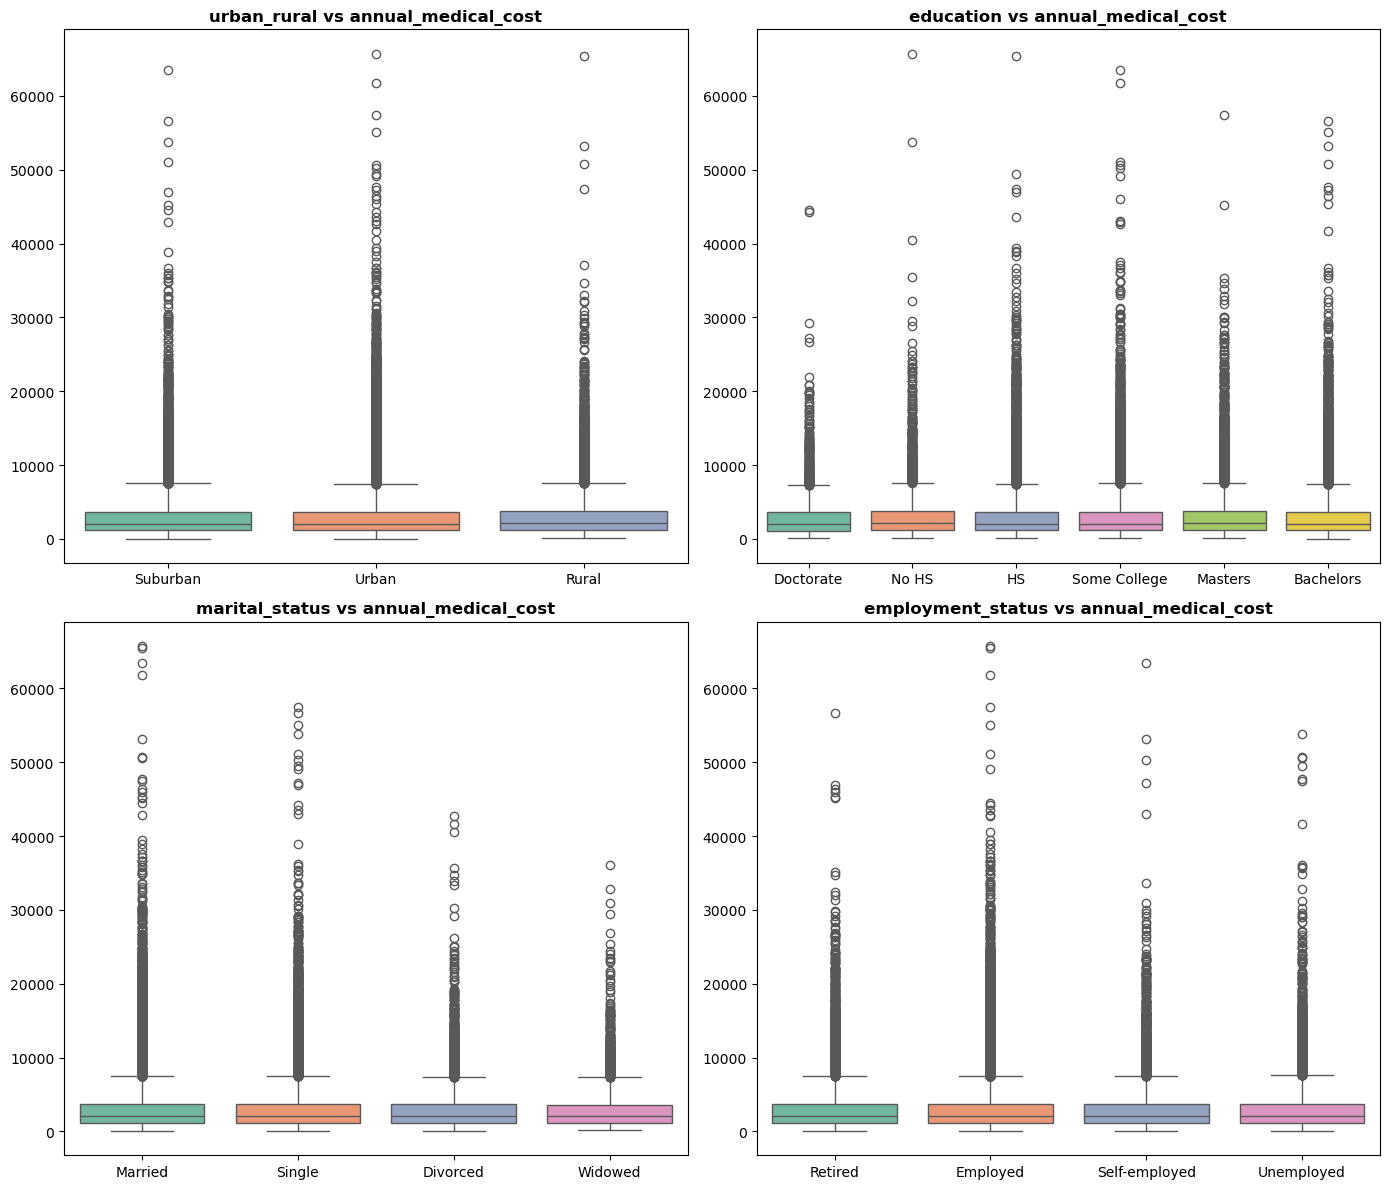

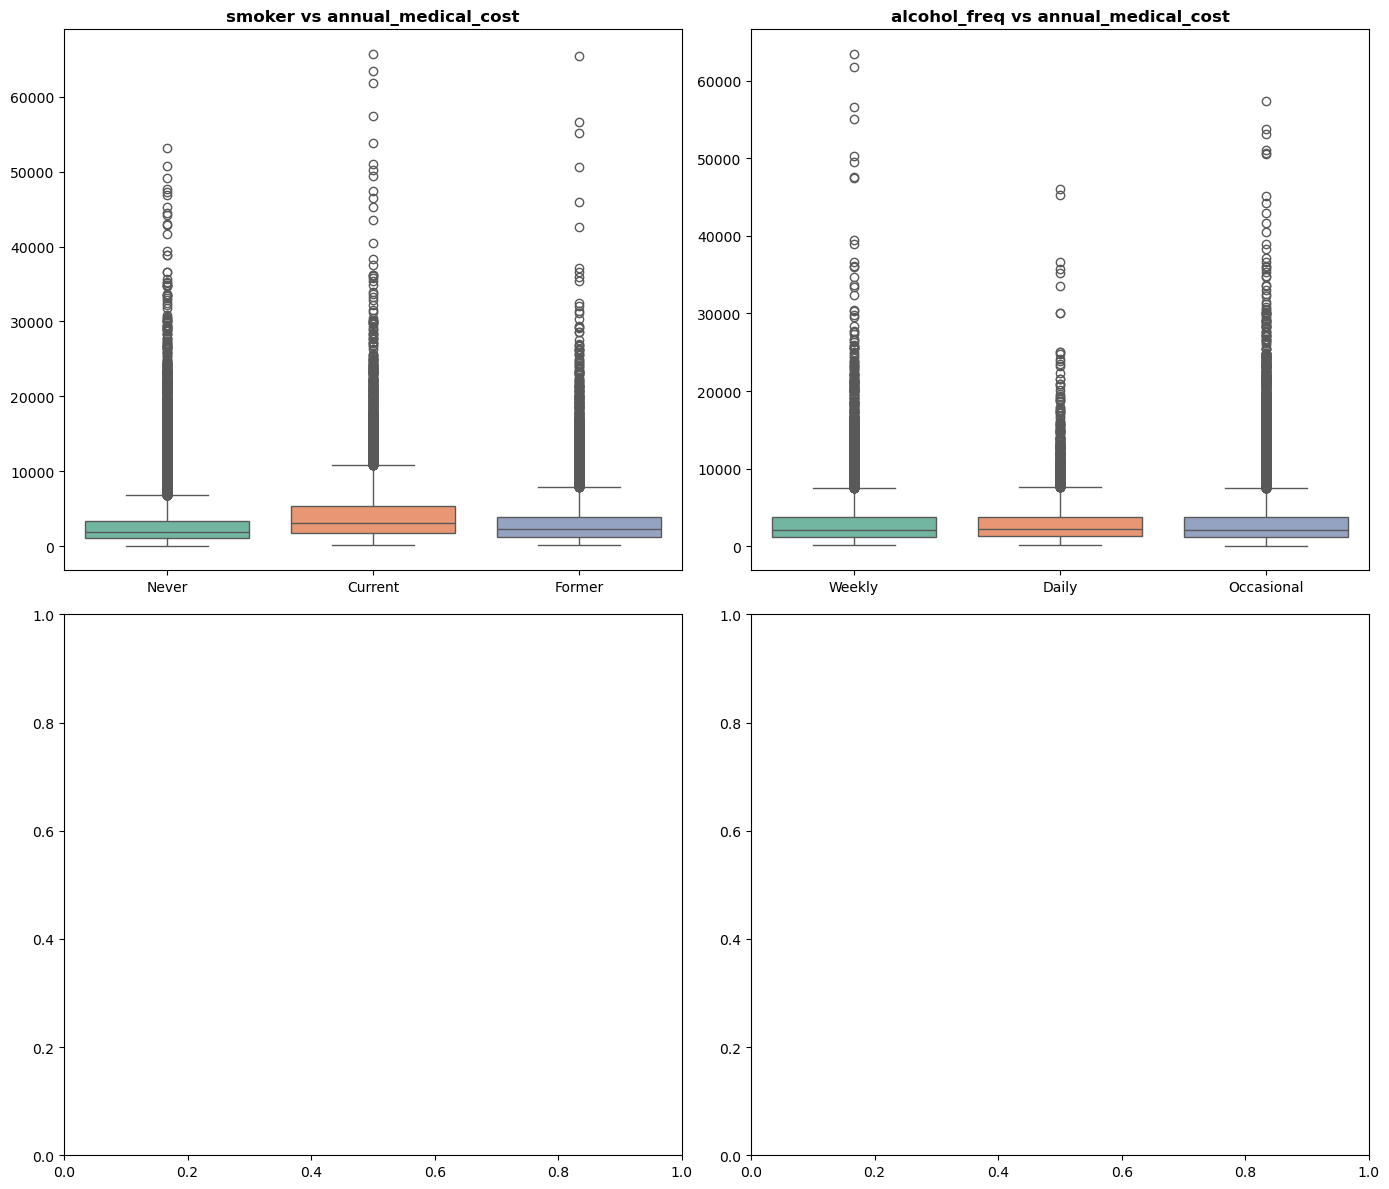

In [43]:
def plot_batch(batch_cols, batch_number):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(batch_cols):
        ax = axes[i]
        if col in categorical_cols:
            sns.boxplot(x=col, y=target, data=df, ax=ax, palette="Set2", 
                       hue=col, dodge=False, legend=False)
        else:
            sns.scatterplot(x=col, y=target, data=df, ax=ax, color="brown")
        
        ax.set_title(f'{col} vs {target}', fontsize=12, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

plot_batch(columns[0:4], 1)
plot_batch(columns[4:8], 2)
plot_batch(columns[8:12], 3)
plot_batch(columns[12:14], 4)

In [44]:
df.columns.tolist()

['age',
 'sex',
 'region',
 'urban_rural',
 'income',
 'education',
 'marital_status',
 'employment_status',
 'household_size',
 'dependents',
 'bmi',
 'smoker',
 'alcohol_freq',
 'visits_last_year',
 'annual_medical_cost']

In [45]:

ord_cols = [
    'education', 'employment_status', 'smoker', 'alcohol_freq'
]
onehot_cols = [
    'sex', 'region', 'urban_rural', 'marital_status', 
]
df['alcohol_freq'] = df['alcohol_freq'].fillna('None')

# For one-hot encoding - fix the shape mismatch issue
Hotencoder = OneHotEncoder(sparse_output=False)  # Set sparse_output to False
encoded_features = Hotencoder.fit_transform(df[onehot_cols])


# For ordinal encoding
Ordencoder = OrdinalEncoder()
df[ord_cols] = Ordencoder.fit_transform(df[ord_cols])

# Get the feature names from the encoder
feature_names = Hotencoder.get_feature_names_out(onehot_cols)

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=feature_names, index=df.index)

# Drop the original categorical columns and join the encoded ones
df = df.drop(onehot_cols, axis=1).join(encoded_df)

In [46]:
df.columns.tolist()

['age',
 'income',
 'education',
 'employment_status',
 'household_size',
 'dependents',
 'bmi',
 'smoker',
 'alcohol_freq',
 'visits_last_year',
 'annual_medical_cost',
 'sex_Female',
 'sex_Male',
 'sex_Other',
 'region_Central',
 'region_East',
 'region_North',
 'region_South',
 'region_West',
 'urban_rural_Rural',
 'urban_rural_Suburban',
 'urban_rural_Urban',
 'marital_status_Divorced',
 'marital_status_Married',
 'marital_status_Single',
 'marital_status_Widowed']

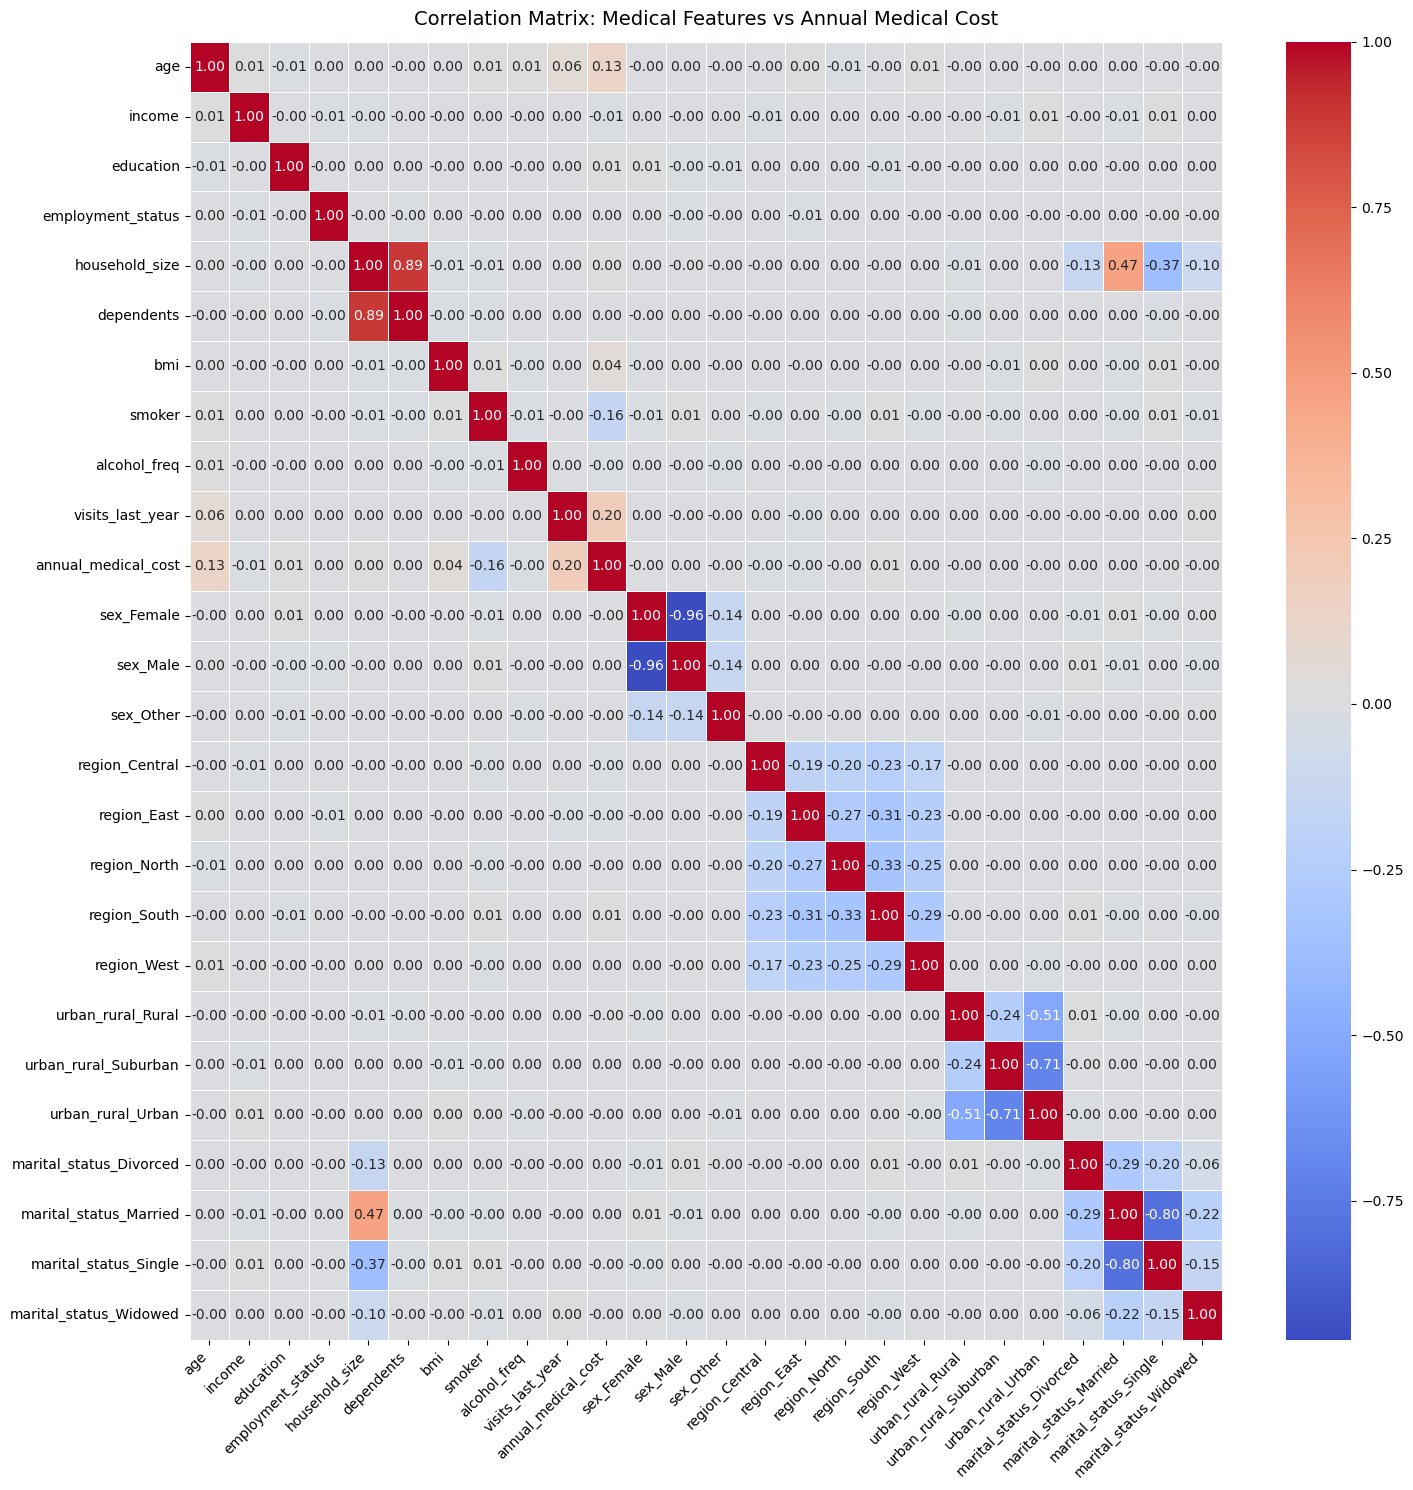

In [47]:
# Now create the correlation matrix
corr = df.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Medical Features vs Annual Medical Cost', fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Feature relevance decision

In [49]:
target_corr = corr['annual_medical_cost'].drop('annual_medical_cost').sort_values(ascending=False)
cols=np.array(df.columns.drop('annual_medical_cost'))
print("FEATURES BY CORRELATION WITH TARGET:")
for feature, corr_value in target_corr.items():
    print(f"{feature:25} : {corr_value:6.3f}")

relevant_features = target_corr[abs(target_corr) > 0.1].index.tolist()
print("\nFEATURES WITH |r| > 0.1:")
for feature in relevant_features:
    print(f"{feature:25} : {target_corr[feature]:6.3f}")

significant_features = []
for feature in cols[1:]:
    corr_coef, p_value = pearsonr(df[feature], df['annual_medical_cost'])
    if p_value < 0.05:
        significant_features.append((feature, corr_coef, p_value))

significant_features.sort(key=lambda x: abs(x[1]), reverse=True)
print("\nSTATISTICALLY SIGNIFICANT FEATURES:")
for feat, corr_val, p_val in significant_features:
    print(f"{feat:25} | {corr_val:10.3f} | {p_val:8.4f}")

high_corr_pairs = []
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if abs(corr.iloc[i, j]) > 0.7 and cols[i] != cols[j]:
            high_corr_pairs.append((cols[i], cols[j], corr.iloc[i, j]))
#proc_surgery_count should be dropped high mu
print("\nHIGHLY CORRELATED FEATURE PAIRS:")
for feat1, feat2, corr_val in high_corr_pairs:
    print(f"{feat1:25} - {feat2:25} : {corr_val:.3f}")

X = df[cols[1:]]
y = df['annual_medical_cost']

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': cols[1:],
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRANDOM FOREST FEATURE IMPORTANCE:")
for _, row in feature_importance.iterrows():
    print(f"{row['feature']:25} | {row['importance']:.4f}")

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

feature_scores = pd.DataFrame({
    'feature': cols[1:],
    'f_score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values('f_score', ascending=False)

print("\nF-TEST FEATURE SCORES:")
for _, row in feature_scores.iterrows():
    print(f"{row['feature']:25} | {row['f_score']:10.2f} | {row['p_value']:8.4f}")

feature_scores_summary = {}
for feature in cols[1:]:
    score = 0
    
    corr_val = abs(target_corr[feature])
    if corr_val > 0.2: score += 3
    elif corr_val > 0.1: score += 2
    elif corr_val > 0.05: score += 1
    
    p_val = feature_scores[feature_scores['feature'] == feature]['p_value'].values[0]
    if p_val < 0.001: score += 3
    elif p_val < 0.01: score += 2
    elif p_val < 0.05: score += 1
    
    rf_rank = feature_importance[feature_importance['feature'] == feature].index[0]
    if rf_rank < 3: score += 2
    elif rf_rank < 6: score += 1
    
    feature_scores_summary[feature] = score

final_scores = sorted(feature_scores_summary.items(), key=lambda x: x[1], reverse=True)

print("\nFINAL FEATURE RANKING:")
for i, (feature, score) in enumerate(final_scores, 1):
    if score >= 4:
        recommendation = "KEEP"
    elif score >= 2:
        recommendation = "KEEP" 
    else:
        recommendation = "DROP"
    print(f"{i:2} | {feature:25} | {score:2} | {recommendation}")

print("\nREDUNDANCY RESOLUTION:")
for feat1, feat2, corr_val in high_corr_pairs:
    corr1 = abs(target_corr[feat1])
    corr2 = abs(target_corr[feat2])
    if corr1 > corr2:
        keep, drop = feat1, feat2
    else:
        keep, drop = feat2, feat1
    print(f"KEEP: {keep:25} | DROP: {drop:25}")

final_features = [feat for feat, score in final_scores if score >= 2]
print(f"\nFINAL FEATURES TO KEEP ({len(final_features)}):")
for feature in final_features:
    print(f"  {feature}")

FEATURES BY CORRELATION WITH TARGET:
visits_last_year          :  0.196
age                       :  0.131
bmi                       :  0.043
region_South              :  0.007
education                 :  0.005
household_size            :  0.004
dependents                :  0.004
employment_status         :  0.003
sex_Male                  :  0.003
urban_rural_Suburban      :  0.003
marital_status_Married    :  0.002
region_West               :  0.002
marital_status_Divorced   :  0.001
urban_rural_Rural         : -0.001
sex_Other                 : -0.001
region_North              : -0.001
urban_rural_Urban         : -0.001
marital_status_Single     : -0.002
marital_status_Widowed    : -0.002
sex_Female                : -0.003
alcohol_freq              : -0.004
region_East               : -0.004
region_Central            : -0.005
income                    : -0.006
smoker                    : -0.156

FEATURES WITH |r| > 0.1:
visits_last_year          :  0.196
age                       :